In [1]:
import keras
from keras.layers import *
from keras.models import Model
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

# 1.DATA

Dataset Original Page: https://www.robots.ox.ac.uk/~vgg/data/flowers/102/

### Loading the Dataset

In [21]:
(ds_train, ds_test), info = tfds.load('oxford_flowers102', split=['test', 'train'], with_info=True)

### Process the Dataset

In [22]:
def process(data):
    return (tf.image.resize(data['image'], (64,64))-177.5)/177.5

train = ds_train.map(process)
test = ds_test.map(process)

In [23]:
train = train.batch(16).prefetch(tf.data.experimental.AUTOTUNE)
test = test.batch(16).prefetch(tf.data.experimental.AUTOTUNE)

In [24]:
train, test

(<_PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>,
 <_PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>)

In [25]:
iter = train.as_numpy_iterator()

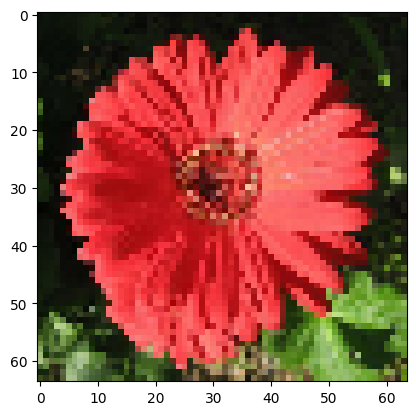

In [47]:
plt.imshow(tf.cast(train.as_numpy_iterator().next()[0]*177.5+177.5,dtype=tf.uint8))

# 2.MODEL

### Optimizer and Loss Functions

In [55]:
gen_opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
disc_opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

def disc_loss(real, fake):
    real_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(real), real)
    fake_loss = tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(fake), fake)
    total_loss = real_loss + fake_loss
    return total_loss

def gen_loss(fake):
    return tf.keras.losses.BinaryCrossentropy()(tf.ones_like(fake), fake)

### Building the Model

In [56]:
class DCGAN(Model):
    def __init__(self, image_shape):
        super(DCGAN, self).__init__()
        self.noise_dim = (100,)
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator(image_shape)


    # Builds the generator
    def build_generator(self):
        input = Input(shape=self.noise_dim)

        # Project and reshape
        x = Dense(4 * 4 * 1024)(input)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Reshape((4, 4, 1024))(x)

        # Upsamplings
        x = Conv2DTranspose(512, 5, (2,2), padding="same", kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.02))(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        x = Conv2DTranspose(256, 5, (2,2), padding="same", kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.02))(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        x = Conv2DTranspose(128, 5, (2,2), padding="same", kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.02))(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        # Output
        out = Conv2DTranspose(3, 5, (2,2), padding="same", activation='tanh', kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.02))(x)

        return Model(inputs=input, outputs=out)


    # Builds the discriminator
    def build_discriminator(self, image_shape):
        input = Input(shape=image_shape)

        # Convolutions
        x = Conv2D(128, 5, (2,2), padding="same", kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.02))(input)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

        x = Conv2D(256, 5, (2,2), padding="same", kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.02))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

        x = Conv2D(512, 5, (2,2), padding="same", kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.02))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

        x = Conv2D(1024, 5, (2,2), padding="same", kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.02))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

        # Output
        x = Flatten()(x)
        out = Dense(1, activation='sigmoid')(x)

        return Model(inputs=input, outputs=out)


    def compile(self, disc_opt_func, gen_opt_func, disc_loss_func, gen_loss_func):
        super().compile()
        self.disc_opt = disc_opt_func
        self.gen_opt = gen_opt_func
        self.disc_loss = disc_loss_func
        self.gen_loss = gen_loss_func


    # Custom train
    def train_step(self, data):
        noise = tf.random.uniform((8,100,))

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(data, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.gen_loss(fake_output)
            disc_loss = self.disc_loss(real_output, fake_output)

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.gen_opt.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
        self.disc_opt.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        return {"total_loss":gen_loss + disc_loss, "gen_loss":gen_loss, "disc_loss":disc_loss}


    # Custom test
    def test_step(self, data):
        noise = tf.random.uniform((8,100,))

        generated_images = self.generator(noise, training=False)

        real_output = self.discriminator(data, training=False)
        fake_output = self.discriminator(generated_images, training=False)

        gen_loss = self.gen_loss(fake_output)
        disc_loss = self.disc_loss(real_output, fake_output)

        return {"total_loss":gen_loss + disc_loss, "gen_loss":gen_loss, "disc_loss":disc_loss}

    def call(self, inputs):
        return self.generator(inputs)

In [57]:
input_shape = (64,64,3)

model = DCGAN(input_shape)
model.compile(disc_opt, gen_opt, disc_loss, gen_loss)

### Training the Model

In [58]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_total_loss', patience=5, restore_best_weights=True)

model.fit(train, epochs=100, validation_data=test)

Epoch 1/100
385/385 [==============================] - 13s 22ms/step - total_loss: 7.3463 - gen_loss: 6.2782 - disc_loss: 1.0681 - val_total_loss: 2.2328 - val_gen_loss: 0.9271 - val_disc_loss: 1.3057
Epoch 2/100
385/385 [==============================] - 8s 21ms/step - total_loss: 3.4781 - gen_loss: 2.6208 - disc_loss: 0.8573 - val_total_loss: 2.2146 - val_gen_loss: 0.4649 - val_disc_loss: 1.7497
Epoch 3/100
385/385 [==============================] - 8s 20ms/step - total_loss: 3.2017 - gen_loss: 2.2624 - disc_loss: 0.9394 - val_total_loss: 3.1594 - val_gen_loss: 0.0865 - val_disc_loss: 3.0730
Epoch 4/100
385/385 [==============================] - 8s 20ms/step - total_loss: 3.0698 - gen_loss: 2.1336 - disc_loss: 0.9362 - val_total_loss: 3.7060 - val_gen_loss: 0.0383 - val_disc_loss: 3.6677
Epoch 5/100
385/385 [==============================] - 8s 21ms/step - total_loss: 2.9824 - gen_loss: 2.1160 - disc_loss: 0.8663 - val_total_loss: 3.3276 - val_gen_loss: 1.6833 - val_disc_loss: 1.6443

### Testing the Model

#### Original Images

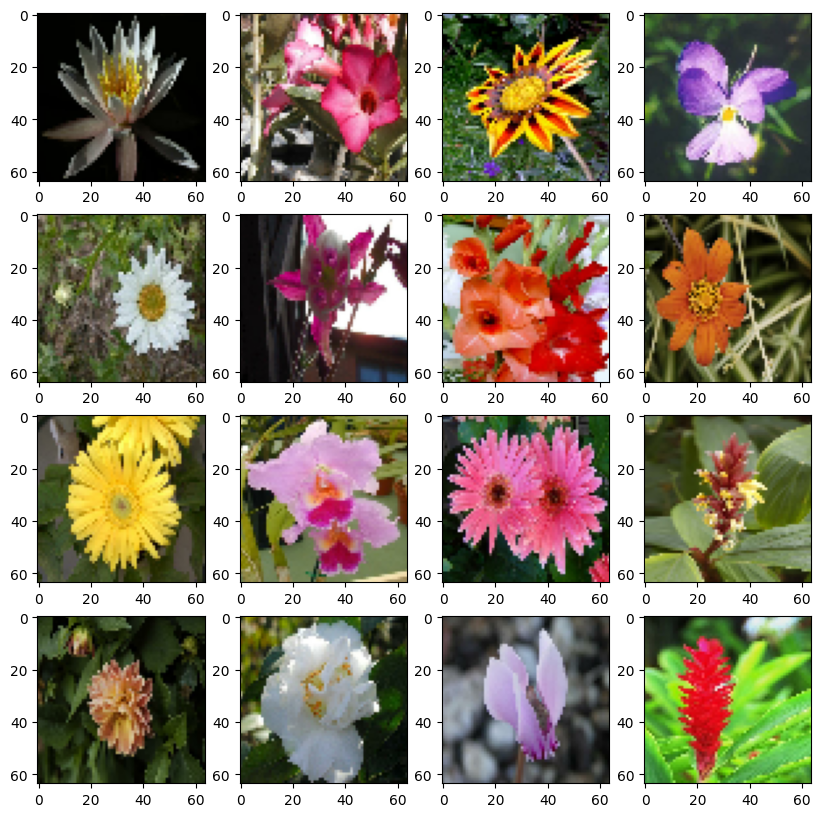

In [72]:
samples = test.as_numpy_iterator().next()

fig, ax = plt.subplots(4,4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        ax[i][j].imshow(tf.cast(samples[i*4+j]*177.5+177.5, dtype=tf.uint8))

#### Generated Images

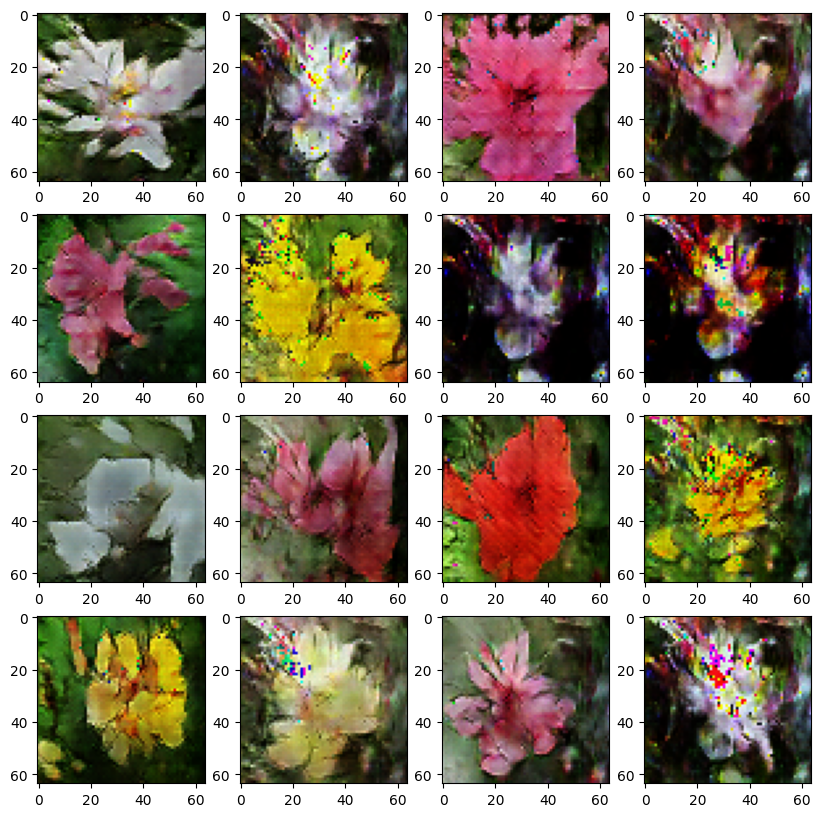

In [71]:
noise = tf.random.uniform((16,100,))
images = model(noise, training=False)

fig, ax = plt.subplots(4,4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        ax[i][j].imshow(tf.cast(images[i*4+j]*177.5+177.5, dtype=tf.uint8))

### Saving the Model

In [67]:
tf.saved_model.save(model, 'DCGAN_Model')